In [198]:
options(digits = 16)
library(leaps)
library(ggplot2)
library(GGally)
library(glmnet)
library(tidyverse)
library(Metrics)
library(glmnet)
library(utils)
library(dplyr)
library(ggcorrplot)
library(plotly)
library(car)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [199]:
url<-"https://raw.githubusercontent.com/YitongZhang01/Predictive-Model/main/insurance.csv"

In [200]:
insurance <- read_csv(url)

Rows: 1338 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (5): index, age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [201]:
sex <- as.factor(insurance$sex)
bmi <- insurance$bmi
children <- insurance$children
smoker <- as.factor(insurance$smoker)
region <- as.factor(insurance$region)
charges <- insurance$charges
head(insurance)
nrow(insurance)

index,age,sex,bmi,children,smoker,region,charges
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


[1] 1338

# Exploratory Data Analysis (EDA)

In [202]:
# Check for missing values in the entire data frame
sum(is.na(insurance))

[1] 0

**No missing value**

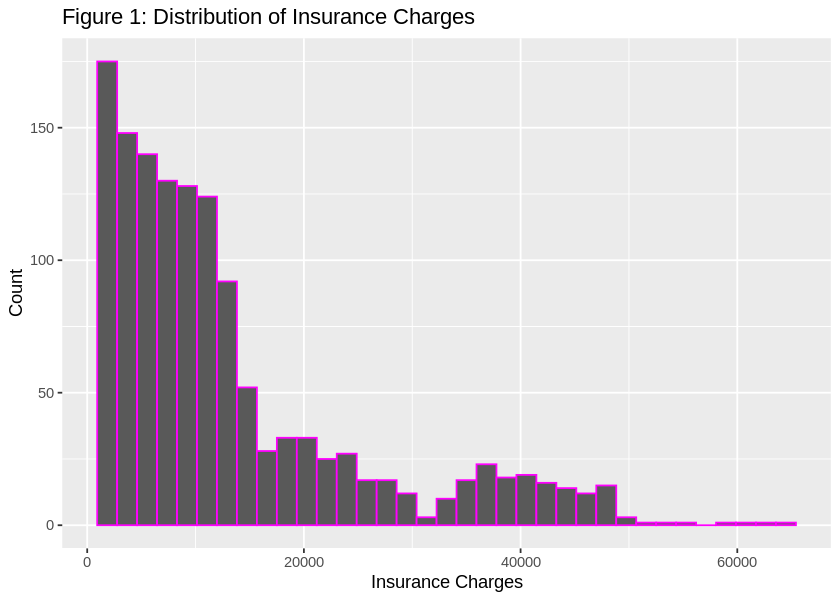

In [203]:
options(repr.plot.width = 7, repr.plot.height = 5)

insurance_charge_dist <- insurance %>% ggplot() +
    geom_histogram(aes(x = charges), bins = 35, color = '#FF00FF') +
    ggtitle('Figure 1: Distribution of Insurance Charges') +
    labs(x = 'Insurance Charges', y = 'Count')

insurance_charge_dist

**The distribution appears not normal, we need to use log() function to before fitting our model**


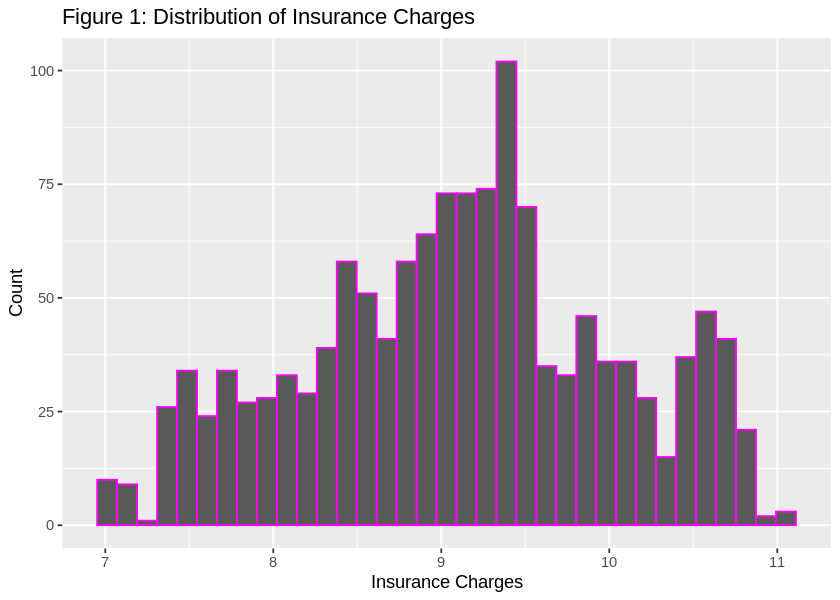

In [204]:
options(repr.plot.width = 7, repr.plot.height = 5)

insurance_charge_dist <- insurance %>% ggplot() +
    geom_histogram(aes(x = log(charges)), bins = 35, color = '#FF00FF') +
    ggtitle('Figure 1: Distribution of Insurance Charges') +
    labs(x = 'Insurance Charges', y = 'Count')

insurance_charge_dist

In [205]:
# Estimates of data
insurance_summarized <- insurance %>% summarize(age = mean(age), 
                                                   bmi = mean(bmi),
                                                    children = mean(children), 
                                                    log_charges = mean(log_charges))
insurance_summarized

ERROR: [1m[33mError[39m in `summarize()`:[22m
[1m[22m[36mℹ[39m In argument: `log_charges = mean(log_charges)`.
[1mCaused by error in `h()`:[22m
[33m![39m error in evaluating the argument 'x' in selecting a method for function 'mean': object 'log_charges' not found


*Next, let us plot the relationship of Insurance charge with the other variables using ggpairs.*

In [ ]:
ggpairs(insurance,columns = c("charges", "bmi", "age", "children"),
        mapping = aes(color = smoker, shape = sex, alpha = 0.5))

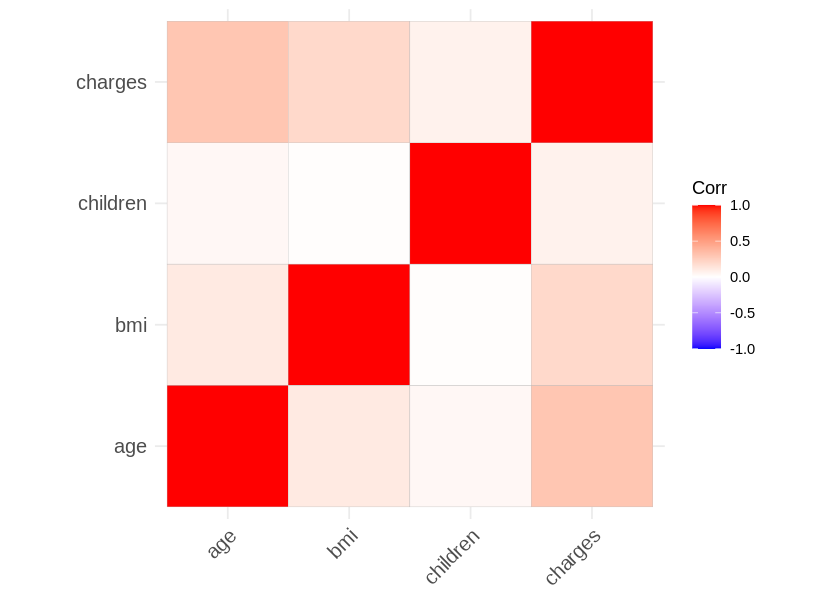

In [206]:
# plot a heat map of the correlation matrix
corr <- cor(insurance[,c("age", "bmi", "children", "charges")],)
ggcorrplot(corr, type = "full") + labs(color = "Correlation", y = "Charges")

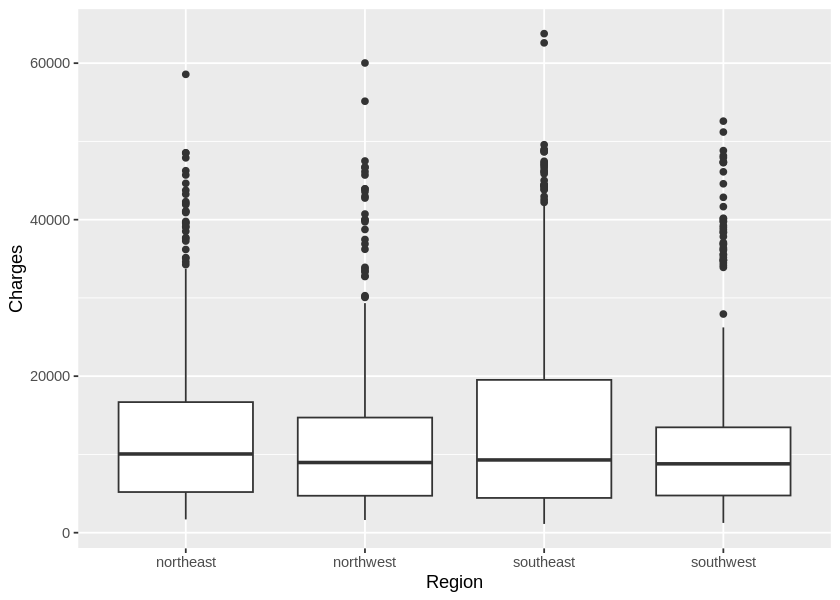

In [207]:
# plot the distribution of charges across different regions
ggplot(insurance, aes(x = region, y = charges)) + geom_boxplot() + labs(x = "Region", y = "Charges")

In [208]:
# create an interactive scatter plot of age, BMI, and charges
plot_ly(insurance, x = age, y = bmi, z = charges, type = "scatter3d", mode = "markers", marker = list(size = 2)) %>%
  layout(scene = list(xaxis = list(title = "Age"),
                      yaxis = list(title = "BMI"),
                      zaxis = list(title = "Charges")))

ERROR: Error in plot_ly(insurance, x = age, y = bmi, z = charges, type = "scatter3d", : object 'age' not found


In [ ]:
# plot a pie chart for sex
sex_counts <- table(insurance$sex)
sex_percent <- round(prop.table(sex_counts) * 100, 1)
pie(sex_counts,
    main = "Sex Distribution",
    col = c("lightpink", "lightblue"),
    labels = paste0(names(sex_counts), ": ", sex_percent, "%"),
    cex = 1.2)
# plot a pie chart for smoker
smoker_counts <- table(insurance$smoker)
smoker_percent <- round(prop.table(smoker_counts) * 100, 1)
pie(smoker_counts,
    main = "Smoker Status",
    col = c("white", "grey"),
    labels = paste0(names(smoker_counts), ": ", smoker_percent, "%"),
    cex = 1.2)

# Model Selection

In [275]:
insurance <- insurance %>%
  mutate(log_charges = log(charges))

In [276]:
set.seed(123)
#First split the data into training and testing sets
training_ins<-sample_n(insurance,size=nrow(insurance)*0.8,
                       replace = FALSE)
testing_ins<-anti_join(insurance,training_ins,by = "index")
training_ins<-dplyr::select(training_ins,-index)
testing_ins<-dplyr::select(testing_ins,-index)

head(training_ins)
nrow(training_ins)

head(testing_ins)
nrow(testing_ins)


age,sex,bmi,children,smoker,region,charges,log_charges
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
19,female,35.150,0,no,northwest,2134.901500000000,7.666175788767053
62,female,38.095,2,no,northeast,15230.324049999999,9.631043722747554
46,female,28.900,2,no,southwest,8823.279000000000,9.085148848619458
18,female,33.880,0,no,southeast,11482.634850000000,9.348591160089185
18,male,34.430,0,no,southeast,1137.469700000000,7.036561513107688
39,female,24.225,5,no,northwest,8965.795749999999,9.101172143951779


[1] 1070

age,sex,bmi,children,smoker,region,charges,log_charges
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
56,female,39.820,0,no,southeast,11090.71780,9.313863803227299
27,male,42.130,0,yes,southeast,39611.75770,10.586881264789202
60,female,36.005,0,no,northeast,13228.84695,9.490155099115842
30,female,32.400,1,no,southwest,4149.73600,8.330799996743426
63,female,23.085,0,no,northeast,14451.83515,9.578576685476762
19,female,28.600,5,no,southwest,4687.79700,8.452718028271507


[1] 268

In [277]:
ins_forward_sel <- regsubsets(x = charges~(.)^2, data = training_ins, nbest = 1, nvmax = 8, method = "forward")
ins_forward_sel_sum<- summary(ins_forward_sel)
ins_forward_sel_sum

Subset selection object
Call: regsubsets.formula(x = charges ~ (.)^2, data = training_ins, 
    nbest = 1, nvmax = 8, method = "forward")
42 Variables  (and intercept)
                            Forced in Forced out
age                             FALSE      FALSE
sexmale                         FALSE      FALSE
bmi                             FALSE      FALSE
children                        FALSE      FALSE
smokeryes                       FALSE      FALSE
regionnorthwest                 FALSE      FALSE
regionsoutheast                 FALSE      FALSE
regionsouthwest                 FALSE      FALSE
log_charges                     FALSE      FALSE
age:sexmale                     FALSE      FALSE
age:bmi                         FALSE      FALSE
age:children                    FALSE      FALSE
age:smokeryes                   FALSE      FALSE
age:regionnorthwest             FALSE      FALSE
age:regionsoutheast             FALSE      FALSE
age:regionsouthwest             FALSE      FALSE

In [278]:
summary_df<-tibble(n_input=1:8,AdjR2 =ins_forward_sel_sum$adjr2,BIC=ins_forward_sel_sum$bic)
summary_df

n_input,AdjR2,BIC
<int>,<dbl>,<dbl>
1,0.8005124029766890,-1711.894015992014
2,0.9033830973624809,-2481.669192074828
3,0.9278639928293417,-2788.351462146792
4,0.9623313865332607,-3477.587211433901
5,0.9647232676247285,-3541.812823350631
6,0.9879613114323440,-4686.198484223909
7,0.9907532704914577,-4962.555609033922
8,0.9913371337821250,-5026.378184997507


In [279]:
# The model has the smallest BIC
which.min(summary_df$BIC)
# The model with 4 parameters.
ins_forward_sel_sum$which[4,]

[1] 8

(Intercept)                         age 
                       TRUE                       FALSE 
                    sexmale                         bmi 
                      FALSE                       FALSE 
                   children                   smokeryes 
                      FALSE                        TRUE 
            regionnorthwest             regionsoutheast 
                      FALSE                       FALSE 
            regionsouthwest                 log_charges 
                      FALSE                        TRUE 
                age:sexmale                     age:bmi 
                      FALSE                       FALSE 
               age:children               age:smokeryes 
                      FALSE                       FALSE 
        age:regionnorthwest         age:regionsoutheast 
                      FALSE                       FALSE 
        age:regionsouthwest             age:log_charges 
                      FALSE                       FALSE 
                sexmale:bmi            sexmale:children 
                      FALSE                       FALSE 
          sexmale:smokeryes     sexmale:regionnorthwest 
                      FALSE                       FALSE 
    sexmale:regionsoutheast     sexmale:regionsouthwest 
                      FALSE                       FALSE 
        sexmale:log_charges                bmi:children 
                      FALSE                       FALSE 
              bmi:smokeryes         bmi:regionnorthwest 
                       TRUE                       FALSE 
        bmi:regionsoutheast         bmi:regionsouthwest 
                      FALSE                       FALSE 
            bmi:log_charges          children:smokeryes 
                      FALSE                       FALSE 
   children:regionnorthwest    children:regionsoutheast 
                      FALSE                       FALSE 
   children:regionsouthwest        children:log_charges 
                      FALSE                       FALSE 
  smokeryes:regionnorthwest   smokeryes:regionsoutheast 
                      FALSE                       FALSE 
  smokeryes:regionsouthwest       smokeryes:log_charges 
                      FALSE                        TRUE 
regionnorthwest:log_charges regionsoutheast:log_charges 
                      FALSE                       FALSE 
regionsouthwest:log_charges 
                      FALSE

# Our Model 1 will include the following variables: 'age','children','smoker','bmi:smoker'. #
***We will use log(charges to fit model, since we checked chagres is not normally distributed.***



In [301]:
full_model<-lm(log_charges~., data = training_ins)
summary(full_model)


Call:
lm(formula = log_charges ~ ., data = training_ins)

Residuals:
              Min                1Q            Median                3Q 
-1.16057215942614 -0.10726809281751  0.02969927552483  0.11929950944121 
              Max 
 1.02878396133140 

Coefficients:
                           Estimate          Std. Error   t value   Pr(>|t|)
(Intercept)      7.691774500152e+00  5.878681410547e-02 130.84183 < 2.22e-16
age              2.036299085690e-02  7.682484290929e-04  26.50574 < 2.22e-16
sexmale         -6.853777459382e-02  1.868912611401e-02  -3.66725 0.00025734
bmi             -4.146347946971e-03  1.697938171304e-03  -2.44199 0.01476914
children         7.049809543936e-02  7.761417183089e-03   9.08315 < 2.22e-16
smokeryes        2.729043757622e-01  4.310159058714e-02   6.33165 3.5757e-10
regionnorthwest -4.997251069469e-02  2.665092156878e-02  -1.87508 0.06105699
regionsoutheast -1.101071683637e-01  2.677506980141e-02  -4.11230 4.2203e-05
regionsouthwest -8.142875134750e-02  2

In [282]:
model1 <- lm(log_charges ~ age + children + smoker + bmi*smoker, data = training_ins)
summary(model1)


Call:
lm(formula = log_charges ~ age + children + smoker + bmi * smoker, 
    data = training_ins)

Residuals:
              Min                1Q            Median                3Q 
-0.92948206379008 -0.18088002999763 -0.04024443899693  0.05461039471147 
              Max 
 2.09760251261971 

Coefficients:
                        Estimate         Std. Error  t value Pr(>|t|)    
(Intercept)   7.3160970775884042 0.0847804559151970 86.29462  < 2e-16 ***
age           0.0338949449924122 0.0009675146083462 35.03301  < 2e-16 ***
children      0.0979525692971082 0.0110665574472819  8.85122  < 2e-16 ***
smokeryes     0.1765511590734568 0.1623134710362359  1.08772  0.27697    
bmi           0.0011473548228245 0.0025276469900765  0.45392  0.64998    
smokeryes:bmi 0.0444959709265464 0.0051515265584525  8.63743  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4354380711886 on 1064 degrees of freedom
Multiple R-squared:  0.773884788918

In [283]:
vif(lm(log_charges ~ ., data = insurance))

,GVIF,Df,GVIF^(1/(2*Df))
index,1.003462636099061,1,1.001729821907615
age,1.374726062689936,1,1.172487126876000
sex,1.009034959199991,1,1.004507321625876
bmi,1.224926026680508,1,1.106763762815041
children,1.013615732337206,1,1.006784849080083
smoker,3.549701403778327,1,1.884065127265596
region,1.104640857486416,3,1.016725034257681
charges,4.015348365072421,1,2.003833417495681


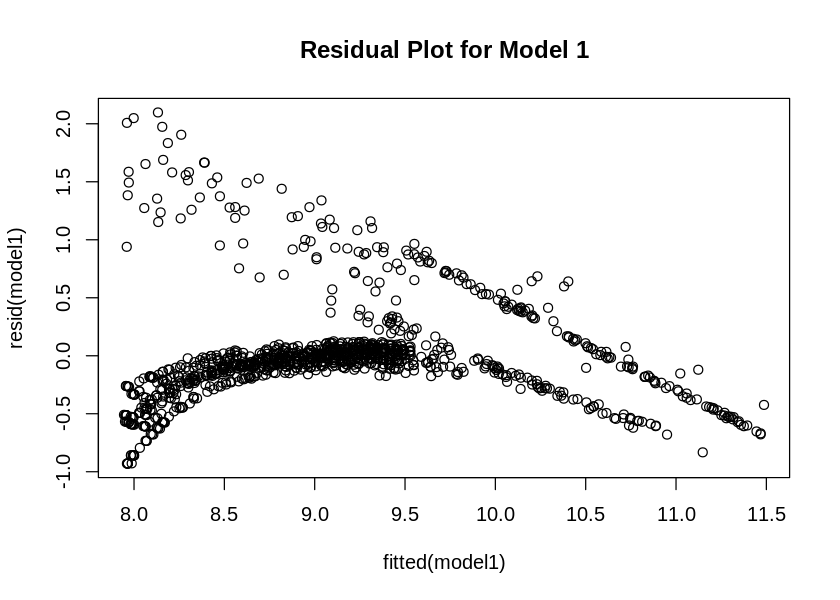

In [302]:
# Create a residual plot
plot(fitted(model1), resid(model1), main = "Residual Plot for Model 1")

**We observed the non-linear patern, so we want to include a quadratic term in the model to capture non-linear patterns**

In [303]:
model2 <- lm(log_charges ~ age + I((age-mean(age))^2) + children + smoker + bmi*smoker, data = training_ins)
summary(model2)


Call:
lm(formula = log_charges ~ age + I((age - mean(age))^2) + children + 
    smoker + bmi * smoker, data = training_ins)

Residuals:
              Min                1Q            Median                3Q 
-0.88777713965911 -0.19080732172635 -0.05731140440723  0.05723814932198 
              Max 
 2.13405246400078 

Coefficients:
                                  Estimate          Std. Error  t value
(Intercept)             7.350509012823e+00  8.587061910747e-02 85.59981
age                     3.405258378637e-02  9.678312724669e-04 35.18442
I((age - mean(age))^2) -1.942199972055e-04  8.298033295656e-05 -2.34055
children                8.934080451985e-02  1.164015305140e-02  7.67523
smokeryes               1.683319067275e-01  1.620110335902e-01  1.03902
bmi                     1.357275584658e-03  2.523938552165e-03  0.53776
smokeryes:bmi           4.472976568251e-02  5.141690077928e-03  8.69943
                         Pr(>|t|)    
(Intercept)            < 2.22e-16 ***
age         

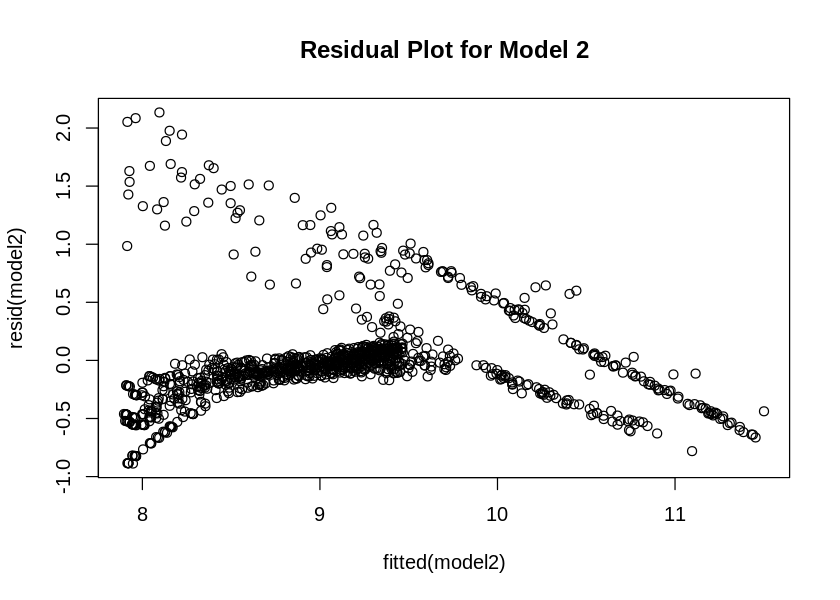

In [304]:
# Create a residual plot
plot(fitted(model2), resid(model2), main = "Residual Plot for Model 2")

In [305]:
prediction<- predict(full_model,newdata = testing_ins)
full_rmse<-rmse(testing_ins$log_charges, prediction)

In [306]:
prediction1 <- predict(model1, newdata = testing_ins)
model1_rmse<-rmse(testing_ins$log_charges, prediction1)

In [307]:
prediction2 <- predict(model2, newdata = testing_ins)
model2_rmse<-rmse(testing_ins$log_charges, prediction2)

In [309]:
rmse_models <- tibble(
  n = 1:3,
  Model = c("Full Model","Model 1", "Model 2"),
  R_MSE = c(full_rmse,model1_rmse,model2_rmse))
rmse_models

n,Model,R_MSE
<int>,<chr>,<dbl>
1,Full Model,0.3091103195709058
2,Model 1,0.4358515778594471
3,Model 2,0.4326632425561366
